In [1]:
from torch import nn
from torchvision import models

# load model
model_resnet18 = models.resnet18(pretrained=False)
num_ftrs = model_resnet18.fc.in_features
# change last layer
num_classes=10
model_resnet18.fc = nn.Linear(num_ftrs, num_classes)

In [2]:
import torch 

# load state_dict into model
path2weights="./models/resnet18_pretrained.pt"
model_resnet18.load_state_dict(torch.load(path2weights))

In [3]:
# set model in evaluation mode
model_resnet18.eval();

In [4]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    model_resnet18=model_resnet18.to(device)

In [5]:
def deploy_model(model,dataset,device, num_classes=10,sanity_check=False):

    len_data=len(dataset)
    
    # initialize output tensor on CPU: due to GPU memory limits
    y_out=torch.zeros(len_data,num_classes)
    
    # initialize ground truth on CPU: due to GPU memory limits
    y_gt=np.zeros((len_data),dtype="uint8")
    
    # move model to device
    model=model.to(device)
    
    elapsed_times=[]
    with torch.no_grad():
        for i in range(len_data):
            x,y=dataset[i]
            y_gt[i]=y
            start=time.time()    
            yy=model(x.unsqueeze(0).to(device))
            y_out[i]=torch.softmax(yy,dim=1)
            elapsed=time.time()-start
            elapsed_times.append(elapsed)

            if sanity_check is True:
                break

    inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms " %(device,inference_time))
    return y_out.numpy(),y_gt

## Loading Test Dataset

In [6]:
from torchvision import datasets
import torchvision.transforms as transforms

# define transformation
data_transformer = transforms.Compose([transforms.ToTensor()])

path2data="./data"

# loading data
test0_ds=datasets.STL10(path2data, split='test', download=True,transform=data_transformer)
print(test0_ds.data.shape)

Files already downloaded and verified
(8000, 3, 96, 96)


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=list(range(len(test0_ds)))
y_test0=[y for _,y in test0_ds]
for test_index, val_index in sss.split(indices, y_test0):
    print("test:", test_index, "val:", val_index)
    print(len(val_index),len(test_index))

test: [2096 4321 2767 ... 3206 3910 2902] val: [6332 6852 1532 ... 5766 4469 1011]
1600 6400


In [8]:
from torch.utils.data import Subset

val_ds=Subset(test0_ds,val_index)
test_ds=Subset(test0_ds,test_index)

In [9]:
mean=[0.4467106, 0.43980986, 0.40664646]
std=[0.22414584,0.22148906,0.22389975]

In [10]:
test0_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    ])   

In [11]:
test0_ds.transform=test0_transformer

In [12]:
import time
import numpy as np

# deploy model 
y_out,y_gt=deploy_model(model_resnet18,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)


average inference time per image on cuda: 3.62 ms 
(1600, 10) (1600,)


In [13]:
from sklearn.metrics import accuracy_score

# get predictions
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)

# compute accuracy 
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)


(1600,) (1600,)
accuracy: 0.88


In [14]:
y_out,y_gt=deploy_model(model_resnet18,test_ds,device=device)

y_pred = np.argmax(y_out,axis=1)
acc=accuracy_score(y_pred,y_gt)
print(acc)

average inference time per image on cuda: 3.53 ms 
0.87828125


image indices: [5157  235 3980 5192]
torch.Size([3, 100, 394])


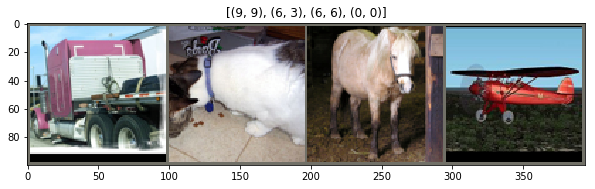

In [15]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(1)

def imshow(inp, title=None):
    mean=[0.4467106, 0.43980986, 0.40664646]
    std=[0.22414584,0.22148906,0.22389975]
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated  

grid_size=4
rnd_inds=np.random.randint(0,len(test_ds),grid_size)
print("image indices:",rnd_inds)

x_grid_test=[test_ds[i][0] for i in rnd_inds]
y_grid_test=[(y_pred[i],y_gt[i]) for i in rnd_inds]

x_grid_test=utils.make_grid(x_grid_test, nrow=4, padding=2)
print(x_grid_test.shape)

plt.rcParams['figure.figsize'] = (10, 5)
imshow(x_grid_test,y_grid_test)

In [16]:
device_cpu = torch.device("cpu")
y_out,y_gt=deploy_model(model_resnet18,val_ds,device=device_cpu,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cpu: 13.95 ms 
(1600, 10) (1600,)
